# FIN 514 - Project 3 Choice #5 Python Codes
**Spring 2022**

This notebook provides a Mote Carlo Code to value **Auto Callable Yield Notes Linked to the Lesser Performing
of the Russell 2000® Index and the S&P 500® Index due May 23, 2023**
Fully and Unconditionally Guaranteed by JPMorgan Chase & Co.

Team members: Ya-Yen,Li(yayenli2) / Wei Ting,Chao(wtchao3) / Yu-Shiuan,Chang(yschang4)

### Part a) Estimated value from Monte Carlo with 2 Underlyings

### Part b) Volatility Sensitive Analysis

### Part c) Correlation Sensitive Analysis

### Part d) Time Steps analysis (Continuous barrier)

### Part e) Value Distribution

## Packages and Configurations

The following common packages will be use on this notebook.
* numpy - [https://numpy.org/](https://numpy.org/)
* Pandas - [https://pandas.pydata.org/](https://pandas.pydata.org/)
* matplotlib - [https://matplotlib.org/](https://matplotlib.org/)
* Scipy Statistical functions - [https://docs.scipy.org/doc/scipy/reference/stats.html](https://docs.scipy.org/doc/scipy/reference/stats.html)

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import random

# Part a) Estimated value from Monte Carlo with 2 Underlyings

## Step 1: Calculate the correlation of 2 underlyings

In [2]:
# Get S&P500's and Russell2000's price return from yahoo finance (1 years)
df = pdr.get_data_yahoo(["^RUT", "^GSPC"], start = "2021-01-01", end="2021-12-31")["Adj Close"]
df

Symbols,^RUT,^GSPC
Date,,
2021-01-04,1945.910034,3700.649902
2021-01-05,1979.109985,3726.860107
2021-01-06,2057.919922,3748.139893
2021-01-07,2096.889893,3803.790039
2021-01-08,2091.659912,3824.679932
...,...,...
2021-12-27,2261.459961,4791.189941
2021-12-28,2246.510010,4786.350098
2021-12-29,2249.239990,4793.060059


In [3]:
# Calculate the correlation between S&P500 and Russell2000
np.log(df/df.shift(1)).corr()

Symbols,^RUT,^GSPC
Symbols,,
^RUT,1.00000,0.74553
^GSPC,0.74553,1.00000


## Step 2: Set the parameters

In [4]:
random.seed(1)

In [5]:
N = 10000                          # Number of Simulations
NA = 2                             # Number of Assets (S&P500 and Russell2000)
M = 454                            # Days for checking continuouss barrier (trigger event) (2/18/2022 ~ 5/18/2023)
S0_Russell = 2009.333              # Original Stock Price (2/18/2022) (Russell2000)
S0_SP = 4348.87                    # Original Stock Price (2/18/2022) (S&P500)
sigma_Russell = 0.26120            # Annualized (Future) Volatility of Returns (Russell2000)
sigma_SP = 0.22289                 # Annualized (Future) Volatility of Returns (S&P500)
rho_RS = 0.74553                   # Correlation between S&P500 and Russell2000 (1 year)
r = 0.0124803                      # Annualized Continously Compounded Risk-free Rate
q_Russell = 0.01316                # Continuous Dividend Yield (Russell2000)
q_SP = 0.01561                     # Continuous Dividend Yield (S&P500)
TM = 459/365                       # Time of Maturity Date (5/23/2023)
TFR = 454/365                      # Time of Final Review Date (5/18/2023)
CPN = 25.125                       # Coupon Payements per month
Trigger_Russell = 0.75*S0_Russell  # Trigger Barrier (Russell2000)
Trigger_SP = 0.75*S0_SP            # Trigger Barrier (S&P500)

In [6]:
S0 = [S0_Russell, S0_SP]                  # Original Stock Price (Russell2000 / S&P500)
sigma = [sigma_Russell, sigma_SP]         # Annualized (Future) Volatility of Returns (Russell2000 / S&P500)
q = [q_Russell, q_SP]                     # Continuous Dividend Yield (Russell2000 / S&P500)
rho = [[1, rho_RS],[rho_RS, 1]]           # Correlation (Russell2000 / S&P500)
Trigger = [Trigger_Russell, Trigger_SP]   # Trigger Barrier (Russell2000 / S&P500)

In [7]:
# Cholesky Factorisation
C = np.linalg.cholesky(rho)
C

array([[1.        , 0.        ],
       [0.74553   , 0.66647207]])

In [8]:
# Review dates for autocall (Final Review Date TFM not included)
Review_dates = [181/365, 273/365, 368/365]

# Payment dates for coupons from T2-T4 (Maturity Date TM NOT included) 
Payment_dates = [186/365, 278/365, 371/365] 

# Payment dates for coupons only on T1 (no autocall)
CPN_payment_dates = [94/365]

In [9]:
# Check for dates

# delta t
dt = TFR / M
print(f"dt: {dt}")

# Review dates for autocall from T2~T4 (Final Review Date TFR NOT included)
ireview1 = [i/dt for i in Review_dates]      
ireview = [int(i) for i in ireview1]     
print(f"ireview:   {ireview}")

# Payment dates for coupons from T2~T4 (Maturity Date TM NOT included) 
ipayment1 = [i/dt for i in Payment_dates]  
ipayment = [int(i) for i in ipayment1]
print(f"ipayment:  {ipayment}")

# Payment dates for coupons T1 (coupon only date)
icpn1 = [i/dt for i in CPN_payment_dates]      
icpn = [int(i) for i in icpn1]     
print(f"icpn:      {icpn}")

# Payment dates for all coupons from T1~T4 (Maturity Date TM NOT included) 
itotal = icpn + ipayment
print(f"itotal:    {itotal}")

dt: 0.0027397260273972603
ireview:   [181, 273, 368]
ipayment:  [186, 278, 371]
icpn:      [94]
itotal:    [94, 186, 278, 371]


## Step 3: Build the Monte Carlo function

In [10]:
def Monte2D(N, NA, M, S0, TFR, TM, r, q, sigma, Trigger, C):
    
    random.seed(1)
    
    # LIST TO SAVE RESULTS
    V = np.zeros([N])        # List to save option value for each simulation
    S = np.zeros([NA])
    drift = np.zeros([NA])
    
    # Set up time steps
    dt = TFR / M
    
    # Review dates for autocall from T2~T4 (Final Review Date TFR NOT included)
    ireview1 = [i/dt for i in Review_dates]      
    ireview = [int(i) for i in ireview1]    

    # Payment dates for coupons from T2~T4 (Maturity Date TM NOT included)  
    ipayment1 = [i/dt for i in Payment_dates]        
    ipayment = [int(i) for i in ipayment1]       
    
    # Payment dates for coupons T1 (coupon only date)
    icpn1 = [i/dt for i in CPN_payment_dates]       
    icpn = [int(i) for i in icpn1]      
    
    # Payment dates for all coupons from T1~T4 (Maturity Date TM NOT included) 
    itotal = icpn + ipayment

    ### N times of simulations
    for i in range(0, N):
        VM = np.zeros([M+1])  # List to save option value for single simulation
        Flag_AC = 0           # Flag for autocall i.e. if it is autocall, Flag_AC = 1
        Flag_Trigger = 0      # Falg for trigger i.e. if trigger event occurs, Flag_Trigger = 1
        Prior_S = S0 
        
        ### Days for checking the continuous barrier (trigger event)  
        for j in range(1, M+1):
            
            # Calculate phi and diffusuion terms for two underlyings' price
            phi = []
            for k in range (0,NA):
                phi.append(np.random.normal(0,1))  # Calculate the normally distrubuted random number
            diffusion = np.matmul(C,phi)
            
            # Calculate every time steps' stock price
            for k in range (0, NA):
                drift[k] = (r-q[k]-0.5*sigma[k]**2)*dt
                S[k] = Prior_S[k]*np.exp(drift[k]+sigma[k]*np.sqrt(dt)*diffusion[k])
            Prior_S = S
            
            # Calculate option value
            VM[j] = VM[j-1] * np.exp(r * dt)
            
            # Coupon only date
            if j in icpn:
                VM[j] += CPN
                
            # Autocall dates (T2~T4)
            if j in ireview:
                if Flag_AC == 0:                        # Autocall NOT occur before
                    if S[0] >= S0[0] or S[1] >= S0[1]:  # Autocall occurs
                        Flag_AC = 1
                        VM[j] += (1000 + CPN) * np.exp(-r * (ipayment[ireview.index(j)] * dt - j * dt))
                    else:                               # Autocall NOT occur
                        VM[j] += CPN * np.exp(-r * (ipayment[ireview.index(j)] * dt - j * dt))
                        # ipayment[ireview.index(j)]: time of coupon date
                    
            # Check if trigger event occurs (continuous barrier)
            if S[0] < Trigger[0] or S[1] < Trigger[1]: 
                Flag_Trigger = 1
                
            # At Final Review Date (TFR)
            if j == M:
                if Flag_AC == 0:  # Autocall NOT occur before                                            
                    # Both index are higher than initial value or trigger event NOT occur
                    if (S[0] >= S0[0] and S[1] >= S0[1]) or Flag_Trigger == 0:  
                        VM[j] += (1000 + CPN) * np.exp(-r * (TM - TFR))
                     
                    # Either index is less than initial value and trigger occurs 
                    if (S[0] < S0[0] or S[1] < S0[1]) and Flag_Trigger == 1:                              
                        Return = (S - S0) / S0
                        Lesser_return = min(Return)
                        VM[j] += (1000 * (1 + Lesser_return) + CPN)* np.exp(-r * (TM - TFR))
                        
        V[i] = VM[M]
     
    # Average all possible values and discount back to pricing date
    Note_value = np.exp(-r * TFR)*np.sum(V)/N

    return Note_value

In [11]:
mc2d = Monte2D(N, NA, M, S0, TFR, TM, r, q, sigma, Trigger, C)
mc2d

992.5534541175607

# Part b) Volatility Sensitive Analysis

In [12]:
# Volatities from review dates (Russell2000 / S&P500)
vol = [[0.28320, 0.22547],  # 2022/08/18 (ATM)
       [0.39156, 0.35407],  # 2022/08/18 (moneyness 75)
       [0.26999, 0.22627],  # 2022/11/18 (ATM)
       [0.35481, 0.33015],  # 2022/11/18 (moneyness 75)
       [0.26782, 0.22421],  # 2023/02/21 (ATM)
       [0.34723, 0.31388],  # 2023/02/21 (moneyness 75)
       [0.26120, 0.22289],  # 2023/05/18 (ATM)
       [0.33036, 0.30345]]  # 2023/05/18 (moneyness 75)

In [13]:
# List to save the value 
value_result = []

# Value with different volatilities
for i in vol:
    note_value = Monte2D(N, NA, M, S0, TFR, TM, r, q, i, Trigger, C)
    output = {'Volatility': i, 'Value': note_value}
    value_result.append(output)

In [14]:
# Print value with different volatilities
value_result

[{'Volatility': [0.2832, 0.22547], 'Value': 987.9604865799228},
 {'Volatility': [0.39156, 0.35407], 'Value': 947.9646888816837},
 {'Volatility': [0.26999, 0.22627], 'Value': 988.4921487038392},
 {'Volatility': [0.35481, 0.33015], 'Value': 960.3172765273366},
 {'Volatility': [0.26782, 0.22421], 'Value': 991.811006851518},
 {'Volatility': [0.34723, 0.31388], 'Value': 964.6973492999763},
 {'Volatility': [0.2612, 0.22289], 'Value': 992.5015802763897},
 {'Volatility': [0.33036, 0.30345], 'Value': 966.4751025706552}]

# Part c) Correlation Sensitive Analysis (1, 3, 5, 10 years correlation)

In [15]:
# Get S&P500's and Russell2000's price return from yahoo finance (3 years)
df_3y = pdr.get_data_yahoo(["^RUT", "^GSPC"], start = "2018-01-01", end="2021-12-31")["Adj Close"]

In [16]:
# Calculate the correlation between S&P500 and Russell2000
np.log(df_3y/df_3y.shift(1)).corr()

Symbols,^RUT,^GSPC
Symbols,,
^RUT,1.000000,0.879776
^GSPC,0.879776,1.000000


In [17]:
# Get S&P500's and Russell2000's price return from yahoo finance (5 years)
df_5y = pdr.get_data_yahoo(["^RUT", "^GSPC"], start = "2016-01-01", end="2021-12-31")["Adj Close"]

In [18]:
# Calculate the correlation between S&P500 and Russell2000
np.log(df_5y/df_5y.shift(1)).corr()

Symbols,^RUT,^GSPC
Symbols,,
^RUT,1.000000,0.876427
^GSPC,0.876427,1.000000


In [19]:
# Get S&P500's and Russell2000's price return from yahoo finance (10 years)
df_10y = pdr.get_data_yahoo(["^RUT", "^GSPC"], start = "2011-01-01", end="2021-12-31")["Adj Close"]

In [20]:
# Calculate the correlation between S&P500 and Russell2000
np.log(df_10y/df_10y.shift(1)).corr()

Symbols,^RUT,^GSPC
Symbols,,
^RUT,1.000000,0.892052
^GSPC,0.892052,1.000000


In [21]:
# Correlation of different time length (Russell2000 / S&P500)
corr = [0.74553,  # 1 year
        0.879776, # 3 year
        0.876427, # 5 year
        0.892052] # 10 year

In [22]:
# List to save the value 
value_result = []

# Value with different volatilities
for j in corr:
    new_rho = [[1, j],[j, 1]]
    new_C = np.linalg.cholesky(new_rho)
    note_value = Monte2D(N, NA, M, S0, TFR, TM, r, q, sigma, Trigger, new_C)
    output = {'Correlation': j, 'Value': note_value}
    value_result.append(output)

In [23]:
# Print value with different correlations
value_result

[{'Correlation': 0.74553, 'Value': 990.5619797852123},
 {'Correlation': 0.879776, 'Value': 991.2140098547079},
 {'Correlation': 0.876427, 'Value': 991.0688069485948},
 {'Correlation': 0.892052, 'Value': 989.9980802075706}]

### Volatility and correlation sensitive analysis

In [24]:
# Volatities from review dates (Russell2000 / S&P500)
vol = [[0.28320, 0.22547],  # 2022/08/18 (ATM)
       [0.39156, 0.35407],  # 2022/08/18 (moneyness 75)
       [0.26999, 0.22627],  # 2022/11/18 (ATM)
       [0.35481, 0.33015],  # 2022/11/18 (moneyness 75)
       [0.26782, 0.22421],  # 2023/02/21 (ATM)
       [0.34723, 0.31388],  # 2023/02/21 (moneyness 75)
       [0.26120, 0.22289],  # 2023/05/18 (ATM)
       [0.33036, 0.30345]]  # 2023/05/18 (moneyness 75)

# Correlation of different time length (Russell2000 / S&P500)
corr = [0.74553,  # 1 year
        0.879776, # 3 year
        0.876427, # 5 year
        0.892052] # 10 year

In [25]:
# List to save the value 
value_result = []

# Value with different volatilities
for i in vol:
    for j in corr:
        new_rho = [[1, j],[j, 1]]
        new_C = np.linalg.cholesky(new_rho)
        note_value = Monte2D(N, NA, M, S0, TFR, TM, r, q, i, Trigger, new_C)
        output = {'Volatility': i, 'Correlation': j, 'Value': note_value}
        value_result.append(output)

In [26]:
# Print value with different volatilities
value_result

[{'Volatility': [0.2832, 0.22547],
  'Correlation': 0.74553,
  'Value': 988.124804615674},
 {'Volatility': [0.2832, 0.22547],
  'Correlation': 0.879776,
  'Value': 986.8346150687829},
 {'Volatility': [0.2832, 0.22547],
  'Correlation': 0.876427,
  'Value': 986.0527238784628},
 {'Volatility': [0.2832, 0.22547],
  'Correlation': 0.892052,
  'Value': 983.3812610703208},
 {'Volatility': [0.39156, 0.35407],
  'Correlation': 0.74553,
  'Value': 949.1604862145447},
 {'Volatility': [0.39156, 0.35407],
  'Correlation': 0.879776,
  'Value': 947.2383605243493},
 {'Volatility': [0.39156, 0.35407],
  'Correlation': 0.876427,
  'Value': 947.0579570146668},
 {'Volatility': [0.39156, 0.35407],
  'Correlation': 0.892052,
  'Value': 947.2166640063822},
 {'Volatility': [0.26999, 0.22627],
  'Correlation': 0.74553,
  'Value': 991.5527627517996},
 {'Volatility': [0.26999, 0.22627],
  'Correlation': 0.879776,
  'Value': 988.7867272965938},
 {'Volatility': [0.26999, 0.22627],
  'Correlation': 0.876427,
  'Va

# Part d) Time Steps analysis (Continuous barrier)

In [27]:
# List to save the value 
value_result_TimeSteps = []

# Check for trigger event [Twice a day, daily, weekly, monthly]
Time_steps = [2*M, M, int(M/7), int(M/30)]

In [28]:
# Value with different time steps
for i in Time_steps:
    note_value = Monte2D(N, NA, i, S0, TFR, TM, r, q, sigma, Trigger, C)
    output = {'Time Step': i, 'Value': note_value}
    value_result_TimeSteps.append(output)

In [29]:
# Print value with different time steps
value_result_TimeSteps

[{'Time Step': 908, 'Value': 991.6536388765194},
 {'Time Step': 454, 'Value': 992.9318533273986},
 {'Time Step': 64, 'Value': 993.7058171739187},
 {'Time Step': 15, 'Value': 999.9244935457716}]

# Part e) Value Distribution

In [30]:
new_sigma = [0.2832, 0.22547]                 # Annualized (Future) Volatility of Returns (Russell2000 / S&P500)                 # Continuous Dividend Yield (Russell2000 / S&P500)
new_rho = [[1, 0.892052],[0.892052, 1]]       # Correlation (Russell2000 / S&P500)
new_C = np.linalg.cholesky(new_rho)           # Cholesky Factorisation

In [31]:
def Monte2D_Distribution(N, NA, M, S0, TFR, TM, r, q, sigma, Trigger, C):
    
    random.seed(1)
    
    #LIST TO SAVE RESULTS
    monte2d_result = []
    
    for trial in range(0, 1000):
        print(trial)
        
        # LIST TO SAVE RESULTS
        V = np.zeros([N])        # List to save option value for each simulation
        S = np.zeros([NA])
        drift = np.zeros([NA])
    
        # Set up time steps
        dt = TFR / M
    
        # Review dates for autocall from T2~T4 (Final Review Date TFR NOT included)
        ireview1 = [i/dt for i in Review_dates]      
        ireview = [int(i) for i in ireview1]    

        # Payment dates for coupons from T2~T4 (Maturity Date TM NOT included)  
        ipayment1 = [i/dt for i in Payment_dates]        
        ipayment = [int(i) for i in ipayment1]       
    
        # Payment dates for coupons T1 (coupon only date)
        icpn1 = [i/dt for i in CPN_payment_dates]       
        icpn = [int(i) for i in icpn1]      
    
        # Payment dates for all coupons from T1~T4 (Maturity Date TM NOT included) 
        itotal = icpn + ipayment

        ### N times of simulations
        for i in range(0, N):
            VM = np.zeros([M+1])  # List to save option value for single simulation
            Flag_AC = 0           # Flag for autocall i.e. if it is autocall, Flag_AC = 1
            Flag_Trigger = 0      # Falg for trigger i.e. if trigger event occurs, Flag_Trigger = 1
            Prior_S = S0 
        
            ### Days for checking the continuous barrier (trigger event)  
            for j in range(1, M+1):
                
                # Calculate phi and diffusuion terms for two underlyings' price
                phi = []
                for k in range (0,NA):
                    phi.append(np.random.normal(0,1))  # Calculate the normally distrubuted random number
                diffusion = np.matmul(C,phi)
            
                # Calculate every time steps' stock price
                for k in range (0, NA):
                    drift[k] = (r-q[k]-0.5*sigma[k]**2)*dt
                    S[k] = Prior_S[k]*np.exp(drift[k]+sigma[k]*np.sqrt(dt)*diffusion[k])
                Prior_S = S
            
                # Calculate option value
                VM[j] = VM[j-1] * np.exp(r * dt)
            
                # Coupon only date
                if j in icpn:
                    VM[j] += CPN
                
                # Autocall dates (T2~T4)
                if j in ireview:
                    if Flag_AC == 0:                        # Autocall NOT occur before
                        if S[0] >= S0[0] or S[1] >= S0[1]:  # Autocall occurs
                            Flag_AC = 1
                            VM[j] += (1000 + CPN) * np.exp(-r * (ipayment[ireview.index(j)] * dt - j * dt))
                        else:                               # Autocall NOT occur
                            VM[j] += CPN * np.exp(-r * (ipayment[ireview.index(j)] * dt - j * dt))
                            # ipayment[ireview.index(j)]: time of coupon date
                    
                # Check if trigger event occurs (continuous barrier)
                if S[0] < Trigger[0] or S[1] < Trigger[1]: 
                    Flag_Trigger = 1
                
                # At Final Review Date (TFR)
                if j == M:
                    if Flag_AC == 0:  # Autocall NOT occur before                                            
                        # Both index are higher than initial value or trigger event NOT occur
                        if (S[0] >= S0[0] and S[1] >= S0[1]) or Flag_Trigger == 0:  
                            VM[j] += (1000 + CPN) * np.exp(-r * (TM - TFR))
                     
                        # Either index is less than initial value and trigger occurs 
                        if (S[0] < S0[0] or S[1] < S0[1]) and Flag_Trigger == 1:                              
                            Return = (S - S0) / S0
                            Lesser_return = min(Return)
                            VM[j] += (1000 * (1 + Lesser_return) + CPN)* np.exp(-r * (TM - TFR))
                        
            V[i] = VM[M]
     
        # Average all possible values and discount back to pricing date
        Note_value = np.exp(-r * TFR)*np.sum(V)/N
           
        # RELAY OUTPUTS TO DICTIONARY
        output = {'Simulations': N, 'Monte': Note_value}
        monte2d_result.append(output)

    return monte2d_result

In [32]:
mc2d_D = Monte2D_Distribution(N, NA, M, S0, TFR, TM, r, q, new_sigma, Trigger, new_C)
mc2d_D

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

[{'Simulations': 10000, 'Monte': 985.4341207360965},
 {'Simulations': 10000, 'Monte': 984.2035800154954},
 {'Simulations': 10000, 'Monte': 985.4031940971523},
 {'Simulations': 10000, 'Monte': 985.680889449271},
 {'Simulations': 10000, 'Monte': 986.9806351523866},
 {'Simulations': 10000, 'Monte': 981.5224995708588},
 {'Simulations': 10000, 'Monte': 987.3751361667175},
 {'Simulations': 10000, 'Monte': 983.9633866267225},
 {'Simulations': 10000, 'Monte': 983.5871616442198},
 {'Simulations': 10000, 'Monte': 982.5906926931108},
 {'Simulations': 10000, 'Monte': 983.9007349311576},
 {'Simulations': 10000, 'Monte': 985.7390777569009},
 {'Simulations': 10000, 'Monte': 983.7272036134349},
 {'Simulations': 10000, 'Monte': 981.0280438005799},
 {'Simulations': 10000, 'Monte': 984.6603468255429},
 {'Simulations': 10000, 'Monte': 982.9991221519615},
 {'Simulations': 10000, 'Monte': 984.2949863539891},
 {'Simulations': 10000, 'Monte': 982.4439605038174},
 {'Simulations': 10000, 'Monte': 987.5286678609

In [33]:
# CREATE A DATAFRAME FROM THE BINOMIAL MODEL OUTPUT
df_MC_D = pd.DataFrame.from_dict(mc2d_D)
df_MC_D

,Simulations,Monte
0,10000,985.434121
1,10000,984.203580
2,10000,985.403194
3,10000,985.680889
4,10000,986.980635
...,...,...
995,10000,984.713689
996,10000,984.783464
997,10000,986.758057
998,10000,985.722316


In [34]:
# EXPORT THE DATA TO A CSV FILE
#df.to_csv("/Users/changyushiuan/Desktop/2022Spring/FIN514/Project/Project3/monte2d.csv", index=False)

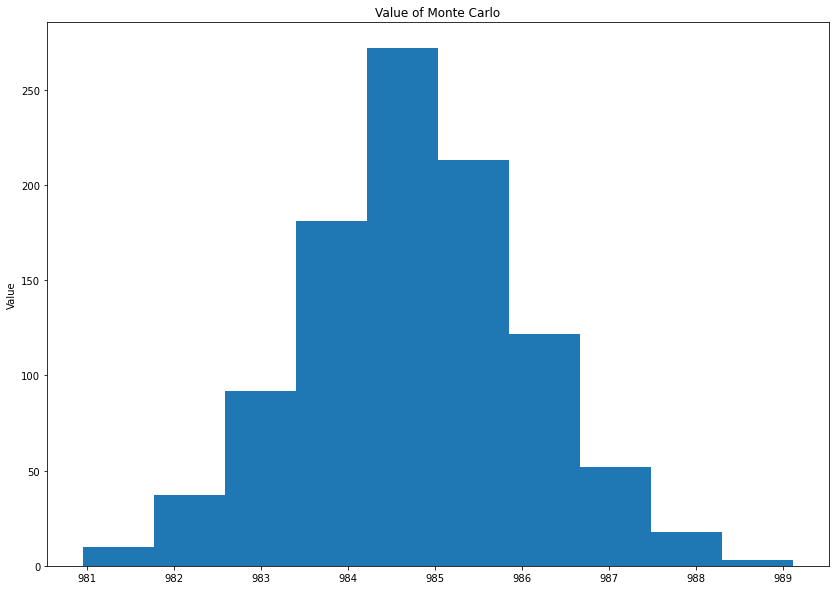

In [35]:
# Draw Distrbution
plt.figure(figsize=(14,10))
plt.hist(df_MC_D['Monte'])
plt.title("Value of Monte Carlo")
plt.ylabel("Value")
plt.show()